# Implementation of BYOL-style Self-Supervised Learning Plastic Object Detection from Seashore using Fine-Tune YOLOv11 backbone

# Setup

In [1]:
!pip install -q -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.7 MB/s eta 0:00:00


In [2]:
# ================================================================
# BYOL on YOLOv11 backbone using Detect pre-hook + 75-epoch fine-tune
# Memory-safe (yolo11s, small crops/batch) 
# ================================================================

import json, shutil, yaml, warnings, gc, random, math, copy, os
from pathlib import Path
from PIL import Image
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt

import os, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from ultralytics import YOLO
import torch, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


warnings.filterwarnings("ignore")
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42); random.seed(42); np.random.seed(42)
torch.backends.cudnn.benchmark = True
print("Device:", device, "| torch", torch.__version__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


# Dataset Path

In [3]:
BASE  = Path("/kaggle/input/plastic-coco/plastic_coco")
WORK  = Path("/kaggle/working/plastic_ssl")
SPLIT = WORK / "0_yolo_split"
DATA  = WORK / "data_plastic.yaml"
SSL_W = WORK / "byol_backbone_with_hooks_y11.pth"   
WORK.mkdir(parents=True, exist_ok=True)

In [4]:
def get_detect_module(model_module):
    """Return the Detect head (robust across YOLO versions)."""
    try:
        last = model_module.model[-1]
        if "Detect" in last.__class__.__name__:
            return last
    except Exception:
        pass
    cand = None
    for m in model_module.modules():
        if "Detect" in m.__class__.__name__:
            cand = m
    return cand if cand is not None else list(model_module.modules())[-1]


# COCO -> YOLO conversion 

In [5]:
def coco2yolo(b, w, h):
    x, y, bw, bh = b
    return (x + bw / 2) / w, (y + bh / 2) / h, bw / w, bh / h

def convert(split, img_dir, ann_json):
    out_im, out_lb = SPLIT / split / "images", SPLIT / split / "labels"
    out_im.mkdir(parents=True, exist_ok=True)
    out_lb.mkdir(parents=True, exist_ok=True)

    coco = json.load(open(ann_json))
    id2 = {im["id"]: im for im in coco["images"]}

    # write labels
    for ann in coco["annotations"]:
        im = id2[ann["image_id"]]
        yb = coco2yolo(ann["bbox"], im["width"], im["height"])
        with open(out_lb / f"{Path(im['file_name']).stem}.txt", "a") as f:
            f.write(f"{ann['category_id']-1} " + " ".join(f"{v:.6f}" for v in yb) + "\n")

    # copy images
    for im in coco["images"]:
        src = Path(img_dir) / im["file_name"]
        dst = out_im / im["file_name"]
        if src.exists():
            shutil.copy(src, dst)
        else:
            print(f"Missing image: {src}")

# ========================
# Run Conversion
# ========================
if not DATA.exists():
    print("➤ Converting COCO → YOLO …")

    convert("train", BASE / "images" / "train", BASE / "annotation" / "train.json")
    convert("valid", BASE / "images" / "val",   BASE / "annotation" / "val.json")
    convert("test",  BASE / "images" / "test",  BASE / "annotation" / "test.json")

    # class names
    categories = json.load(open(BASE / "annotation" / "train.json"))["categories"]
    names = [c["name"] for c in sorted(categories, key=lambda x: x["id"])]

    DATA.write_text(yaml.dump({
        "path": str(SPLIT),
        "train": "train/images",
        "val": "valid/images",
        "test": "test/images",
        "nc": len(names),
        "names": names
    }))
    print("✓ YOLO split ready at", SPLIT)
else:
    print("YOLO split already exists")
    

➤ Converting COCO → YOLO …
✓ YOLO split ready at /kaggle/working/plastic_ssl/0_yolo_split


# Two-view Dataset (SSL)

In [6]:
class TwoView(Dataset):
    SUPP = ('*.jpg','*.JPG','*.jpeg','*.JPEG','*.png','*.PNG','*.bmp','*.BMP','*.webp','*.WEBP')
    def __init__(self, roots, tfm):
        self.files=[]
        for r in roots:
            pr=Path(r)
            for p in self.SUPP:
                self.files.extend(pr.rglob(p))
        if not self.files: raise RuntimeError(f"No images found under {roots}")
        self.tfm=tfm
    def __len__(self): return len(self.files)
    def __getitem__(self,idx):
        img=Image.open(self.files[idx]).convert("RGB")
        return self.tfm(img), self.tfm(img)

augment = transforms.Compose([
    transforms.RandomResizedCrop(160, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3,0.3,0.3,0.1),
    transforms.RandomGrayscale(0.2),
    transforms.GaussianBlur(kernel_size=7, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
])

# BYOL Loss

In [7]:
def byol_loss(p, z):
    p = F.normalize(p, dim=1)
    z = F.normalize(z, dim=1)
    return 2 - 2*(p*z).sum(dim=1).mean()

# Hook to capture neck outputs (P3, P4, P5)

In [8]:
class DetectInputHook:
    def __init__(self, detect_module):
        self.handle = detect_module.register_forward_pre_hook(self.hook)
        self.feats = None
    def hook(self, module, inputs):
        # inputs is a tuple with a single item: a list/tuple of FPN maps [P3,P4,P5]
        self.feats = list(inputs[0])  # keep tensors with grad for online
        return None
    def close(self):
        self.handle.remove()

def global_pool_concat(feats):
    pooled = [F.adaptive_avg_pool2d(f, 1).flatten(1) for f in feats]
    return torch.cat(pooled, dim=1)

# BYOL Pretraining

In [9]:
MODEL = "yolo11s.yaml"     # YOLO11 nano config
SSL_EPOCHS, SSL_BATCH = 75, 16 # EPOCHS and BATCH SIZE
m0 = 0.996

train_losses = []

if SSL_W.exists():
    print("✓ BYOL backbone cached – skipping pre-train")
else:
    print("\n  BYOL pre-training (75 epoch, hook-based, YOLOv11) …")

    # full models (Read neck features via hook)
    online_full = YOLO(MODEL).model.to(device)
    target_full = YOLO(MODEL).model.to(device)
    target_full.load_state_dict(online_full.state_dict())
    for p in target_full.parameters(): p.requires_grad=False

    # register hooks on Detect heads to capture P3,P4,P5
    online_hook = DetectInputHook(get_detect_module(online_full))
    target_hook = DetectInputHook(get_detect_module(target_full))

    # infer feature dim
    with torch.no_grad():
        dmy = torch.zeros(1,3,160,160,device=device)
        _ = online_full(dmy)                # run forward to populate hook
        feat_dim = global_pool_concat(online_hook.feats).shape[1]
    print("Backbone feature dim:", feat_dim)

    def projector():
        return nn.Sequential(
            nn.Linear(feat_dim,512,bias=False),
            nn.BatchNorm1d(512), nn.ReLU(inplace=True),
            nn.Linear(512,256,bias=False)
        )
    def predictor():
        return nn.Sequential(
            nn.Linear(256,512,bias=False),
            nn.BatchNorm1d(512), nn.ReLU(inplace=True),
            nn.Linear(512,256,bias=False)
        )

    proj_o, proj_t = projector().to(device), projector().to(device)
    pred_o         = predictor().to(device)
    proj_t.load_state_dict(proj_o.state_dict())
    for p in proj_t.parameters(): p.requires_grad=False

    # optimize only online_full (backbone+neck) + projector/predictor
    opt = torch.optim.AdamW(
        list(online_full.parameters()) + list(proj_o.parameters()) + list(pred_o.parameters()),
        lr=1e-3, weight_decay=1e-4
    )
    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

    @torch.no_grad()
    def ema_update(src, dst, m):
        for ps, pd in zip(src.parameters(), dst.parameters()):
            pd.data.mul_(m).add_(ps.data, alpha=1-m)

    def momentum_scheduled(step, total_steps, base=m0):
        if total_steps <= 1: return 1.0
        tau = step / (total_steps - 1)
        return 1.0 - (1.0 - base) * (0.5 * (1.0 + math.cos(math.pi * tau)))

    ds = TwoView([SPLIT/"train/images", SPLIT/"valid/images", SPLIT/"test/images"], augment)
    dl = DataLoader(ds, batch_size=SSL_BATCH, shuffle=True,
                    num_workers=0, pin_memory=False, drop_last=True)
    total_steps = max(1, SSL_EPOCHS * len(dl))
    lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=total_steps)
    step = 0
    for ep in range(SSL_EPOCHS):
        online_full.train(); proj_o.train(); pred_o.train()
        running=0.0
        pbar = tqdm(dl, desc=f"BYOL {ep+1}/{SSL_EPOCHS}", leave=False)

        for v1,v2 in pbar:
            v1,v2 = v1.to(device, non_blocking=True), v2.to(device, non_blocking=True)
            m_cur = momentum_scheduled(step, total_steps)

            with torch.autocast(device_type='cuda', enabled=(device=="cuda")):
                # encodes (features captured by hook)
                _ = online_full(v1)
                h1 = global_pool_concat(online_hook.feats)
                _ = online_full(v2)
                h2 = global_pool_concat(online_hook.feats)

                z1_o = proj_o(h1); z2_o = proj_o(h2)
                p1   = pred_o(z1_o); p2 = pred_o(z2_o)

                # target encodes (EMA, no grad)
                with torch.no_grad():
                    ema_update(online_full, target_full, m_cur)
                    ema_update(proj_o, proj_t, m_cur)
                    _ = target_full(v1)
                    h1_t = global_pool_concat(target_hook.feats)
                    _ = target_full(v2)
                    h2_t = global_pool_concat(target_hook.feats)
                    z1_t = proj_t(h1_t); z2_t = proj_t(h2_t)

                loss = byol_loss(p1, z2_t) + byol_loss(p2, z1_t)

            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update(); opt.zero_grad(set_to_none=True)
            running += loss.item()
            step += 1
            pbar.set_postfix(loss=f"{loss.item():.4f}", m=f"{m_cur:.4f}")

        lr_sched.step()
        avg_loss = running / len(dl)  
        train_losses.append(avg_loss)
        
        print(f"Epoch {ep+1}/{SSL_EPOCHS} BYOL loss={avg_loss:.4f}")

        
    # save ONLY backbone+neck weights (exclude Detect head)
    torch.save({k:v for k,v in online_full.state_dict().items()
                if not k.startswith('model.%d' % (len(online_full.model)-1))}, SSL_W)

    online_hook.close(); target_hook.close()
    del online_full, target_full, proj_o, proj_t, pred_o, dl, ds
    gc.collect(); 
    if device=="cuda": torch.cuda.empty_cache()
    print("✓ Saved SSL backbone weights →", SSL_W)


  BYOL pre-training (75 epoch, hook-based, YOLOv11) …
Backbone feature dim: 896


BYOL 1/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 1/75 BYOL loss=1.1078


BYOL 2/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 2/75 BYOL loss=0.8568


BYOL 3/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 3/75 BYOL loss=0.7510


BYOL 4/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 4/75 BYOL loss=0.6742


BYOL 5/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 5/75 BYOL loss=0.9170


BYOL 6/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 6/75 BYOL loss=0.9996


BYOL 7/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 7/75 BYOL loss=0.9085


BYOL 8/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 8/75 BYOL loss=0.7443


BYOL 9/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 9/75 BYOL loss=0.6493


BYOL 10/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 10/75 BYOL loss=0.6376


BYOL 11/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 11/75 BYOL loss=0.6445


BYOL 12/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 12/75 BYOL loss=0.6568


BYOL 13/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 13/75 BYOL loss=0.6210


BYOL 14/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 14/75 BYOL loss=0.6182


BYOL 15/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 15/75 BYOL loss=0.6490


BYOL 16/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 16/75 BYOL loss=0.6201


BYOL 17/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 17/75 BYOL loss=0.5991


BYOL 18/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 18/75 BYOL loss=0.5487


BYOL 19/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 19/75 BYOL loss=0.5439


BYOL 20/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 20/75 BYOL loss=0.5273


BYOL 21/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 21/75 BYOL loss=0.5081


BYOL 22/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 22/75 BYOL loss=0.5074


BYOL 23/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 23/75 BYOL loss=0.4614


BYOL 24/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 24/75 BYOL loss=0.4935


BYOL 25/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 25/75 BYOL loss=0.4753


BYOL 26/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 26/75 BYOL loss=0.4950


BYOL 27/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 27/75 BYOL loss=0.4533


BYOL 28/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 28/75 BYOL loss=0.4447


BYOL 29/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 29/75 BYOL loss=0.4547


BYOL 30/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 30/75 BYOL loss=0.4574


BYOL 31/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 31/75 BYOL loss=0.4332


BYOL 32/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 32/75 BYOL loss=0.4370


BYOL 33/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 33/75 BYOL loss=0.4325


BYOL 34/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 34/75 BYOL loss=0.4553


BYOL 35/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 35/75 BYOL loss=0.4520


BYOL 36/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 36/75 BYOL loss=0.4445


BYOL 37/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 37/75 BYOL loss=0.4605


BYOL 38/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 38/75 BYOL loss=0.4441


BYOL 39/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 39/75 BYOL loss=0.5024


BYOL 40/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 40/75 BYOL loss=0.4195


BYOL 41/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 41/75 BYOL loss=0.4369


BYOL 42/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 42/75 BYOL loss=0.4579


BYOL 43/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 43/75 BYOL loss=0.4210


BYOL 44/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 44/75 BYOL loss=0.4235


BYOL 45/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 45/75 BYOL loss=0.4141


BYOL 46/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 46/75 BYOL loss=0.4180


BYOL 47/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 47/75 BYOL loss=0.4405


BYOL 48/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 48/75 BYOL loss=0.4095


BYOL 49/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 49/75 BYOL loss=0.4268


BYOL 50/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 50/75 BYOL loss=0.4013


BYOL 51/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 51/75 BYOL loss=0.4117


BYOL 52/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 52/75 BYOL loss=0.4227


BYOL 53/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 53/75 BYOL loss=0.4181


BYOL 54/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 54/75 BYOL loss=0.4108


BYOL 55/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 55/75 BYOL loss=0.4282


BYOL 56/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 56/75 BYOL loss=0.4070


BYOL 57/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 57/75 BYOL loss=0.4109


BYOL 58/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 58/75 BYOL loss=0.4154


BYOL 59/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 59/75 BYOL loss=0.4264


BYOL 60/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 60/75 BYOL loss=0.4094


BYOL 61/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 61/75 BYOL loss=0.4098


BYOL 62/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 62/75 BYOL loss=0.4124


BYOL 63/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 63/75 BYOL loss=0.4106


BYOL 64/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 64/75 BYOL loss=0.4091


BYOL 65/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 65/75 BYOL loss=0.3845


BYOL 66/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 66/75 BYOL loss=0.3970


BYOL 67/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 67/75 BYOL loss=0.4003


BYOL 68/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 68/75 BYOL loss=0.4023


BYOL 69/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 69/75 BYOL loss=0.4174


BYOL 70/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 70/75 BYOL loss=0.3992


BYOL 71/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 71/75 BYOL loss=0.4007


BYOL 72/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 72/75 BYOL loss=0.4078


BYOL 73/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 73/75 BYOL loss=0.3899


BYOL 74/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 74/75 BYOL loss=0.4038


BYOL 75/75:   0%|          | 0/231 [00:00<?, ?it/s]

Epoch 75/75 BYOL loss=0.3897
✓ Saved SSL backbone weights → /kaggle/working/plastic_ssl/byol_backbone_with_hooks_y11.pth


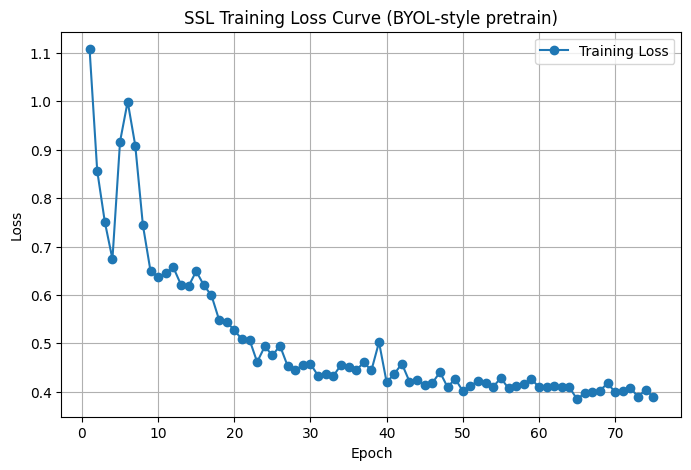

In [10]:
# =============================
# Plot training loss curves
# =============================

plt.figure(figsize=(8,5))
plt.plot(range(1, SSL_EPOCHS+1), train_losses, marker="o", label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SSL Training Loss Curve (BYOL-style pretrain)")
plt.legend()
plt.grid(True)
plt.show()


# Fine-tune YOLOv11 Detector

In [11]:
print("\n Fine-tuning YOLOv11-s (75 epoch) …")
det = YOLO(MODEL)  

sd = torch.load(SSL_W, map_location="cpu")
det.model.load_state_dict(sd, strict=False)

det.train(
    data=str(DATA),
    epochs=75,             
    imgsz=640,
    batch=16,
    patience=20,
    optimizer="AdamW",
    lr0=0.005,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=5,
    cos_lr=True,          
    hsv_h=0.015,
    hsv_s=0.6,
    hsv_v=0.4,
    degrees=0.0,
    translate=0.05,
    scale=0.2,
    shear=0.0,
    perspective=0.0,
    flipud=0.1,
    fliplr=0.5,
    mosaic=0.2,
    mixup=0.0,
    label_smoothing=0.05,
    cache=True,
    rect=True,
    project=str(WORK),
    name="byol_yolo11s",
    device=0 if device=="cuda" else None,
    verbose=True
)



 Fine-tuning YOLOv11-s (75 epoch) …
WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.190 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/plastic_ssl/data_plastic.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.1, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.yaml, momentum=0.937, mosaic=0.2, multi_scale=False, name=byol_yol

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78ecf56bc610>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Evaluate and Visulize one image


 Evaluating …
Ultralytics 8.3.190 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3550.0±425.2 MB/s, size: 926.6 KB)
val: Scanning /kaggle/working/plastic_ssl/0_yolo_split/valid/labels.cache... 742 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 742/742 993352.6it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 186/186 9.6it/s 19.4s
                   all        742      23015      0.516      0.392       0.39      0.173
Speed: 0.3ms preprocess, 18.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/val

Validation metrics
Precision (mP)   : 0.5161
Recall (mR)      : 0.3920
mAP@0.50         : 0.3902
mAP@0.50:0.95    : 0.1726

Visualising: 000002.png


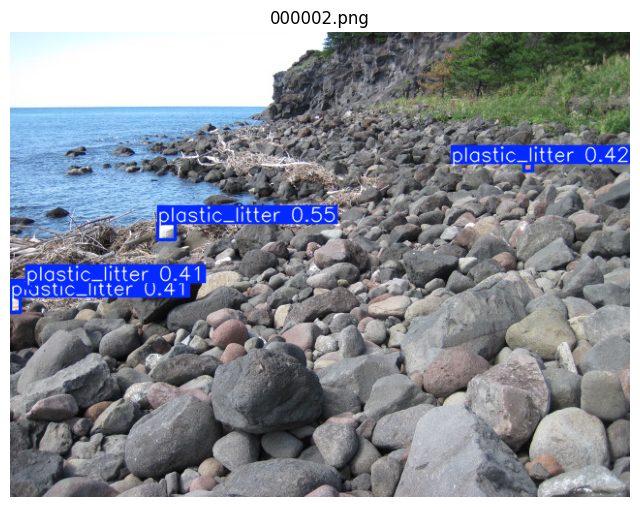

In [12]:

print("\n Evaluating …")
best_pt = WORK/"byol_yolo11s"/"weights"/"best.pt"
model   = YOLO(str(best_pt))
results = model.val(data=str(DATA), imgsz=640, batch=4, device=0 if device=="cuda" else None)

try:
    mp,mr,map50,map5095 = results.mean_results()
    print("\nValidation metrics")
    print(f"Precision (mP)   : {mp:.4f}")
    print(f"Recall (mR)      : {mr:.4f}")
    print(f"mAP@0.50         : {map50:.4f}")
    print(f"mAP@0.50:0.95    : {map5095:.4f}")
except Exception:
    print("Ultralytics API changed; raw results follows:")
    print(results)

cands=list((SPLIT/"test"/"images").glob("*.*")) or list((SPLIT/"valid"/"images").glob("*.*"))
if cands:
    img_path=random.choice(cands)
    print("\nVisualising:", img_path.name)
    pred = model.predict(source=str(img_path), imgsz=640, conf=0.25,
                         device=0 if device=="cuda" else None, verbose=False)[0]
    plt.figure(figsize=(8,8))
    plt.imshow(pred.plot()[:,:,::-1]); plt.axis("off"); plt.title(img_path.name); plt.show()
else:
    print("No images found for visualization.")

# BYOL K-NN Sanity Check


 BYOL k-NN features …


Extract train:   0%|          | 0/35 [00:00<?, ?it/s]

Extract valid:   0%|          | 0/12 [00:00<?, ?it/s]

k-NN accuracy (val): 1.0000


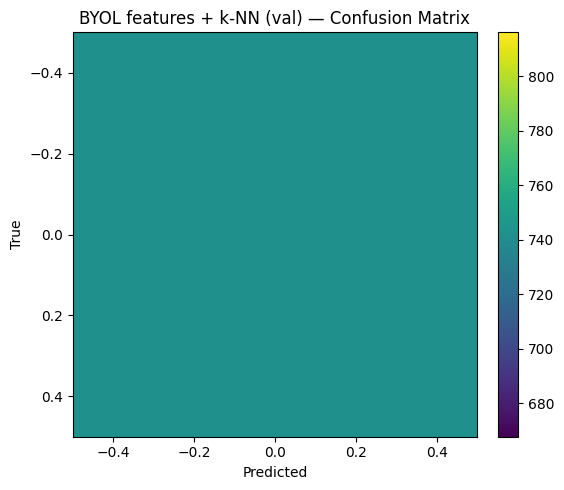

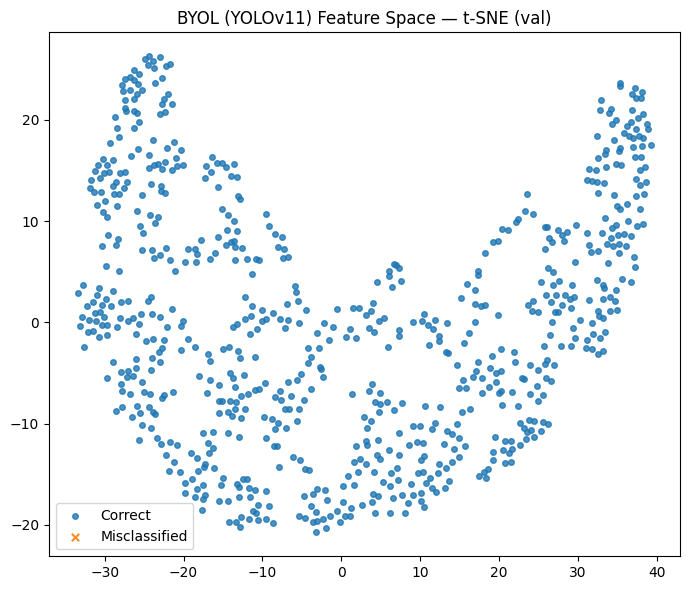


Done ✔


In [13]:
KNN_VIZ = True

if KNN_VIZ:
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import confusion_matrix, accuracy_score
    from sklearn.manifold import TSNE

    def yolo_label_for_image(label_file: Path):
        if not label_file.exists(): return None
        ids=[]
        with open(label_file) as f:
            for line in f:
                parts=line.strip().split()
                if parts:
                    try: ids.append(int(parts[0]))
                    except: pass
        return max(ids, key=ids.count) if ids else None

    def list_images_and_labels(split_dir: Path):
        xs, ys = [], []
        images = sorted((split_dir/"images").glob("*.*"))
        for img_path in images:
            lb_path = (split_dir/"labels"/(img_path.stem + ".txt"))
            lab = yolo_label_for_image(lb_path)
            if lab is None: continue
            xs.append(img_path); ys.append(lab)
        return xs, np.array(ys, dtype=np.int64)

    # rebuild backbone+neck with BYOL weights and capture P3/4/5 again
    feat_model = YOLO("yolo11s.yaml").model.to(device)
    _ = feat_model.load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
    feat_hook  = DetectInputHook(get_detect_module(feat_model))
    feat_model.eval()

    base_tfm = transforms.Compose([transforms.Resize((160,160)), transforms.ToTensor()])

    class ImgDataset(Dataset):
        def __init__(self, paths, tfm): self.paths=paths; self.tfm=tfm
        def __len__(self): return len(self.paths)
        def __getitem__(self,i): return self.tfm(Image.open(self.paths[i]).convert("RGB"))

    def extract_feats(paths, bs=64, desc="Extract"):
        ds  = ImgDataset(paths, base_tfm)
        dl  = DataLoader(ds, batch_size=bs, shuffle=False, num_workers=0, pin_memory=False)
        feats=[]
        for xb in tqdm(dl, desc=desc, leave=False):
            xb = xb.to(device, non_blocking=True)
            with torch.no_grad():
                _ = feat_model(xb)
                h  = global_pool_concat(feat_hook.feats)
            feats.append(h.detach().cpu().numpy())
        return np.concatenate(feats, axis=0) if feats else np.zeros((0,1))

    tr_X, tr_y = list_images_and_labels(SPLIT/"train")
    va_X, va_y = list_images_and_labels(SPLIT/"valid")

    if len(tr_X) and len(va_X):
        print("\n BYOL k-NN features …")
        tr_F = extract_feats(tr_X, bs=64, desc="Extract train")
        va_F = extract_feats(va_X, bs=64, desc="Extract valid")

        if len(tr_F) and len(va_F):
            knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
            knn.fit(tr_F, tr_y)
            va_pred = knn.predict(va_F)
            acc = accuracy_score(va_y, va_pred)
            print(f"k-NN accuracy (val): {acc:.4f}")

            # Confusion matrix
            cm = confusion_matrix(va_y, va_pred)
            plt.figure(figsize=(6,5))
            plt.imshow(cm, interpolation="nearest")
            plt.title("BYOL features + k-NN (val) — Confusion Matrix")
            plt.xlabel("Predicted"); plt.ylabel("True")
            plt.colorbar(fraction=0.046, pad=0.04)
            plt.tight_layout(); plt.show()

            # 2D t-SNE
            if len(va_F) > 10:
                perplex = min(30, max(5, len(va_F)//10))
                tsne = TSNE(n_components=2, init="pca", learning_rate="auto",
                            perplexity=perplex, n_iter=1000, random_state=42)
                Z = tsne.fit_transform(va_F)
                mistakes = (va_pred != va_y)
                plt.figure(figsize=(7,6))
                plt.scatter(Z[~mistakes,0], Z[~mistakes,1], s=16, label="Correct", alpha=0.8)
                plt.scatter(Z[mistakes,0],   Z[mistakes,1],   s=28, marker="x", label="Misclassified", alpha=0.9)
                plt.title("BYOL (YOLOv11) Feature Space — t-SNE (val)")
                plt.legend(); plt.tight_layout(); plt.show()

        feat_hook.close()
        del feat_model
        gc.collect()
        if device=="cuda": torch.cuda.empty_cache()

print("\nDone ✔")

# BYOL PCA visualization

➤ Extracting BYOL features (train/val) …


Extract train:   0%|          | 0/35 [00:00<?, ?it/s]

Extract val:   0%|          | 0/12 [00:00<?, ?it/s]

➤ Standardize + PCA …
PCA 2D explained variance: 81.70%


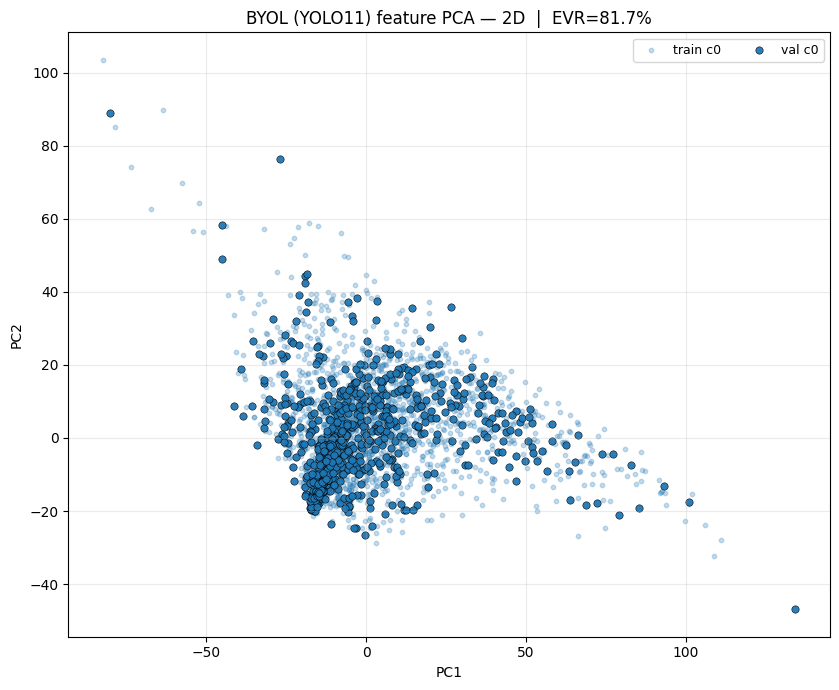

✓ Saved PCA plot → /kaggle/working/plastic_ssl/plots/pca_train_val.png


In [14]:

PLOTS = (WORK / "plots"); PLOTS.mkdir(parents=True, exist_ok=True)

# --- helpers ---
def imread_rgb(path: Path):
    return Image.open(path).convert("RGB")

def yolo_label_for_image(label_file: Path):
    if not label_file.exists(): return None
    ids=[]
    with open(label_file) as f:
        for line in f:
            parts=line.strip().split()
            if parts:
                try: ids.append(int(parts[0]))
                except: pass
    return max(ids, key=ids.count) if ids else None

def list_images_and_labels(split_dir: Path):
    xs, ys = [], []
    images = sorted((split_dir/"images").glob("*.*"))
    for img_path in images:
        lb_path = (split_dir/"labels"/(img_path.stem + ".txt"))
        lab = yolo_label_for_image(lb_path)
        if lab is None: 
            continue
        xs.append(img_path); ys.append(lab)
    return xs, np.array(ys, dtype=np.int64)

def get_detect_module(model_module):
    try:
        last = model_module.model[-1]
        if "Detect" in last.__class__.__name__:
            return last
    except Exception:
        pass
    cand = None
    for m in model_module.modules():
        if "Detect" in m.__class__.__name__:
            cand = m
    return cand if cand is not None else list(model_module.modules())[-1]

class DetectInputHook:
    def __init__(self, detect_module):
        self.handle = detect_module.register_forward_pre_hook(self.hook)
        self.feats = None
    def hook(self, module, inputs):
        self.feats = list(inputs[0])    # [P3,P4,P5]
        return None
    def close(self): self.handle.remove()

def global_pool_concat(feats):
    pooled = [F.adaptive_avg_pool2d(f, 1).flatten(1) for f in feats]
    return torch.cat(pooled, dim=1)

# --- data lists ---
train_X, train_y = list_images_and_labels(SPLIT/"train")
val_X,   val_y   = list_images_and_labels(SPLIT/"valid")
assert len(train_X) and len(val_X), "No labeled images found for PCA visualization."

# --- feature extractor using BYOL weights ---
feat_model = YOLO("yolo11s.yaml").model.to(device)
_ = feat_model.load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
feat_hook  = DetectInputHook(get_detect_module(feat_model))
feat_model.eval()

base_tfm = transforms.Compose([transforms.Resize((160,160)), transforms.ToTensor()])

class ImgDataset(Dataset):
    def __init__(self, paths, tfm): self.paths=paths; self.tfm=tfm
    def __len__(self): return len(self.paths)
    def __getitem__(self,i): return self.tfm(imread_rgb(self.paths[i]))

def extract_feats(paths, bs=64, desc="Extract"):
    ds  = ImgDataset(paths, base_tfm)
    dl  = DataLoader(ds, batch_size=bs, shuffle=False, num_workers=0, pin_memory=False)
    feats=[]
    for xb in tqdm(dl, total=len(dl), desc=desc, leave=False):
        xb = xb.to(device, non_blocking=True)
        with torch.no_grad():
            _ = feat_model(xb)
            h  = global_pool_concat(feat_hook.feats)     # [B, D]
        feats.append(h.detach().cpu().numpy())
    return np.concatenate(feats, axis=0) if feats else np.zeros((0,1))

print("➤ Extracting BYOL features (train/val) …")
train_F = extract_feats(train_X, bs=64, desc="Extract train")
val_F   = extract_feats(val_X,   bs=64, desc="Extract val")

# cleanup hook
feat_hook.close()
del feat_model
if device=="cuda": torch.cuda.empty_cache()

# --- standardize then PCA (fit on train; transform train+val) ---
print("➤ Standardize + PCA …")
scaler = StandardScaler(with_mean=True, with_std=True)
train_Fs = scaler.fit_transform(train_F)
val_Fs   = scaler.transform(val_F)

pca = PCA(n_components=2, random_state=42)
train_P = pca.fit_transform(train_Fs)
val_P   = pca.transform(val_Fs)

evr = pca.explained_variance_ratio_.sum()
print(f"PCA 2D explained variance: {evr*100:.2f}%")

# --- plot ---
plt.figure(figsize=(8.5,7))
classes = np.unique(np.concatenate([train_y, val_y]))
cmap = plt.get_cmap("tab10")

# train (faint)
for c in classes:
    idx = np.where(train_y==c)[0]
    if len(idx):
        plt.scatter(train_P[idx,0], train_P[idx,1], s=10, alpha=0.25, color=cmap(int(c)%10), label=f"train c{c}")

# val (emphasized)
for c in classes:
    idx = np.where(val_y==c)[0]
    if len(idx):
        plt.scatter(val_P[idx,0], val_P[idx,1], s=28, alpha=0.95, edgecolors='k', linewidths=0.4,
                    color=cmap(int(c)%10), marker='o', label=f"val c{c}")

plt.title(f"BYOL (YOLO11) feature PCA — 2D  |  EVR={evr*100:.1f}%")
plt.xlabel("PC1"); plt.ylabel("PC2")
# de-duplicate legend labels
handles, labels = plt.gca().get_legend_handles_labels()
uniq = dict(zip(labels, handles))
plt.legend(uniq.values(), uniq.keys(), fontsize=9, ncol=2, frameon=True)
plt.grid(True, alpha=0.25)
plt.tight_layout()
out_file = PLOTS/"pca_train_val.png"
plt.savefig(out_file, dpi=160)
plt.show()

print(f"✓ Saved PCA plot → {out_file}")


# Save BYOL YOLOv11 Result

In [15]:
# run validation
metrics = det.val(data=str(DATA), split="val")

# collect results
results_dict = {
    "Method": "BYOL-YOLOv11",
    "Backbone": "BYOL-pretrained",
    "Parameters (M)": round(sum(p.numel() for p in det.model.parameters()) / 1e6, 2),
    "Precision": metrics.results_dict["metrics/precision(B)"],
    "Recall": metrics.results_dict["metrics/recall(B)"],
    "F1": (2 * metrics.results_dict["metrics/precision(B)"] * metrics.results_dict["metrics/recall(B)"]) /
          (metrics.results_dict["metrics/precision(B)"] + metrics.results_dict["metrics/recall(B)"] + 1e-9),
    "mAP@0.5": metrics.results_dict["metrics/mAP50(B)"],
    "mAP@0.5:0.95": metrics.results_dict["metrics/mAP50-95(B)"],
}

# save results as JSON
with open("results_byol_yolov11.json", "w") as f:
    json.dump(results_dict, f, indent=4)

print(" Results saved to results_byol_yolov11.json")


Ultralytics 8.3.190 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3910.5±393.1 MB/s, size: 996.7 KB)
val: Scanning /kaggle/working/plastic_ssl/0_yolo_split/valid/labels.cache... 742 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 742/742 1555309.1it/s 0.0s
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.
val: Caching images (0.6GB RAM): 100% ━━━━━━━━━━━━ 742/742 137.4it/s 5.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 47/47 2.8it/s 16.9s
                   all        742      23015      0.517      0.391       0.39      0.173
Speed: 0.5ms preprocess, 15.3ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to /kaggle/working/plastic_ssl/byol_y